# Multi-task residual network implementation

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
cd = os.getcwd()
if cd.endswith('models'):
    os.chdir('..')
os.getcwd()

'/Users/david/Desktop/Monaco-weather-forecast'

In [3]:
from formatting.shaper import MultiTaskShaper
from utils.wrapper import ResidualWrapper

## Data

In [4]:
database = MultiTaskShaper('./data/measurements.nc', './data/nwp.nc')
database.frame()

,ghi,ghi_nwp,t,t_nwp,ws,ws_nwp,wd,wd_nwp,kc,kc_nwp,wx,wx_nwp,wy,wy_nwp
0,0.0,0.000000,286.05,286.641185,11.3,9.935044,250.0,255.651201,0.000000,0.000000,-3.864828e+00,-2.462145,-10.618527,-9.625121
1,0.0,0.000000,286.25,286.823376,10.3,7.109756,250.0,265.533488,0.000000,0.000000,-3.522807e+00,-0.553682,-9.678834,-7.088164
2,0.0,0.000000,285.95,287.202276,8.2,3.753436,260.0,317.499264,0.000000,0.000000,-1.423915e+00,2.767291,-8.075424,-2.535820
3,0.0,0.000000,286.15,286.912173,6.2,6.954706,250.0,44.536117,0.000000,0.000000,-2.120525e+00,4.957374,-5.826094,4.877744
4,9.0,13.455748,286.25,286.533274,5.1,9.967324,270.0,54.962231,0.692308,1.035058,-9.368548e-16,5.722403,-5.100000,8.160984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22027,0.0,0.000000,295.15,295.807986,1.7,8.216769,330.0,50.754985,0.000000,0.000000,1.472243e+00,5.198240,-0.850000,6.363458
22028,0.0,0.000000,295.25,295.764489,2.6,9.031181,330.0,45.740712,0.000000,0.000000,2.251666e+00,6.302921,-1.300000,6.468031
22029,0.0,0.000000,295.35,295.581034,2.5,9.235310,330.0,44.719185,0.000000,0.000000,2.165064e+00,6.562278,-1.250000,6.498266
22030,0.0,0.000000,295.35,295.326192,2.4,9.489244,340.0,48.525199,0.000000,0.000000,2.255262e+00,6.284637,-0.820848,7.109788


## Baseline

In [5]:
base = pd.read_csv('models/baseline.csv', delimiter=';', header='infer', index_col=0)
base_array = base.to_numpy()
base_mse = np.power(base_array[:, 1::2] - base_array[:, ::2], 2).mean(axis=0)
base_mse = {k: v for k, v in zip(base.columns[::2], base_mse)}
base_mse

{'ghi': 1651.9013552745394,
 'ws': 0.8803890562970283,
 't': 0.0849128148285083,
 'wx': 1.180204438417138,
 'wy': 1.2458974081063647}

## Model

In [6]:
n_input = 6
n_output = 1

In [7]:
(X_train, y_train), (X_test, y_test), val = database.get(['ghi', 't', 'wx', 'wy'], ['ghi', 'wx', 'wy'], n_input, n_output)
residual_indexes = database.get_residual_indexes()
database.cols_desc

{'ghi_past_obs': 0,
 'ghi_next_nwp': 1,
 'ghi_past_nwp': 2,
 't_past_obs': 3,
 'wx_past_obs': 4,
 'wx_next_nwp': 5,
 'wx_past_nwp': 6,
 'wy_past_obs': 7,
 'wy_next_nwp': 8,
 'wy_past_nwp': 9}

In [8]:
x_input = layers.Input((n_input, 10))
shared = layers.Flatten()(x_input)
shared = layers.Dense(15, activation='sigmoid')(shared)
shared = layers.Dense(15, activation='relu')(shared)

ghiSpec = layers.Dense(12, activation='relu')(shared)
ghiSpec = layers.Dense(8, activation='relu')(ghiSpec)
ghiSpec = layers.Dense(n_output, activation='linear', name='ghi_out')(ghiSpec)

wxSpec = layers.Dense(12, activation='relu')(shared)
wxSpec = layers.Dense(8, activation='relu')(wxSpec)
wxSpec = layers.Dense(n_output, activation='linear', name='wx_out')(wxSpec)

wySpec = layers.Dense(12, activation='relu')(shared)
wySpec = layers.Dense(8, activation='relu')(wySpec)
wySpec = layers.Dense(n_output, activation='linear', name='wy_out')(wySpec)

model = tf.keras.Model(inputs=x_input, outputs=[ghiSpec, wxSpec, wySpec])
rmtm = ResidualWrapper(model, residual_indexes, n_output)

2022-03-26 18:20:27.322331: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training

In [9]:
val_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

In [10]:
rmtm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={'output_1': 'mse', 'output_2': 'mse', 'output_3': 'mse'},
    loss_weights={'output_1': 3.3/base_mse['ghi'], 'output_2': 3.3/base_mse['wx'], 'output_3': 3.3/base_mse['wy']}
)

In [11]:
history = rmtm.fit(X_train, y_train, validation_data=val, batch_size=32, epochs=40, callbacks=[val_stop], verbose=0)

2022-03-26 18:20:28.026673: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


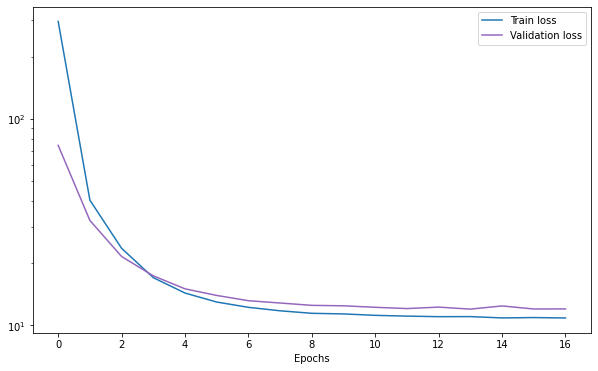

In [12]:
# Plot training history

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train loss', color='tab:blue')
plt.plot(history.history['val_loss'], label='Validation loss', color='tab:purple')
plt.xlabel('Epochs')
plt.yscale('log')
plt.legend()

## Plot results

In [13]:
y_pred = rmtm.predict(X_test)
err = [y1 - y2 for y1, y2 in zip(y_pred, y_test)]

Baseline RMSE : 40.64 | Model RMSE : 43.09
Baseline MAE  : 18.43 | Model MAE  : 18.53


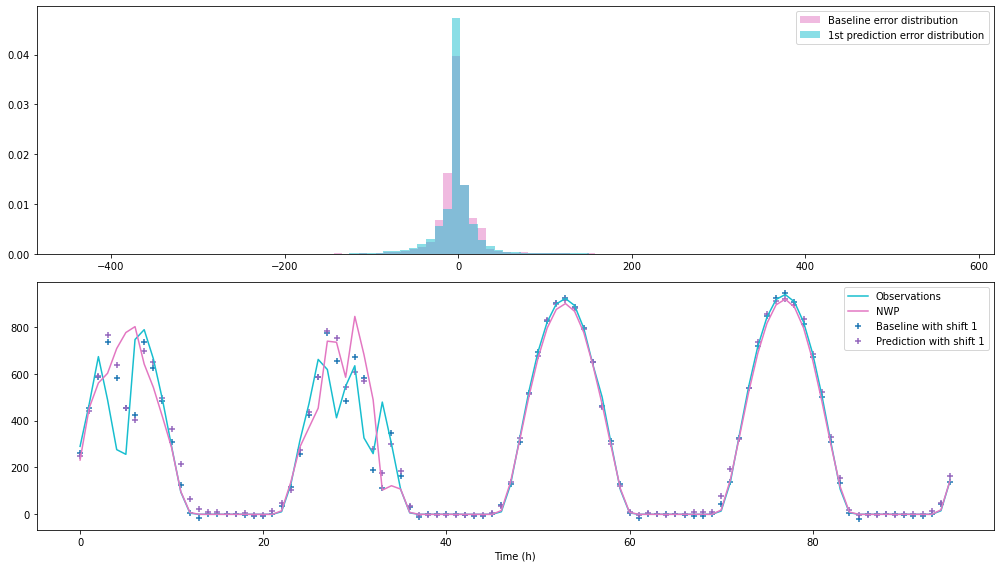

In [14]:
database.plot('ghi', y_pred[0], err[0])

Baseline RMSE : 1.09 | Model RMSE : 1.11
Baseline MAE  : 0.74 | Model MAE  : 0.77


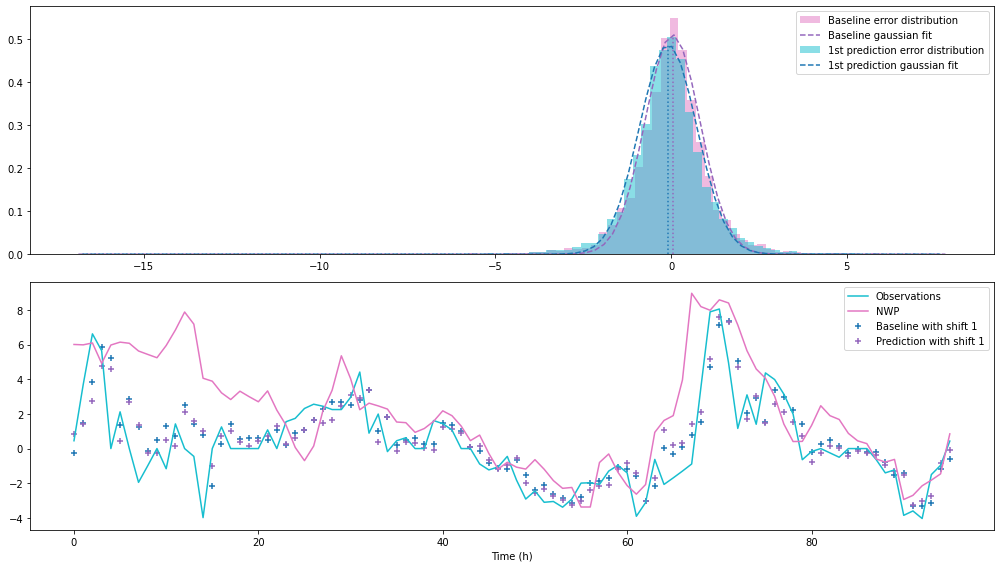

In [15]:
database.plot('wx', y_pred[1], err[1])

Baseline RMSE : 1.12 | Model RMSE : 1.15
Baseline MAE  : 0.75 | Model MAE  : 0.78


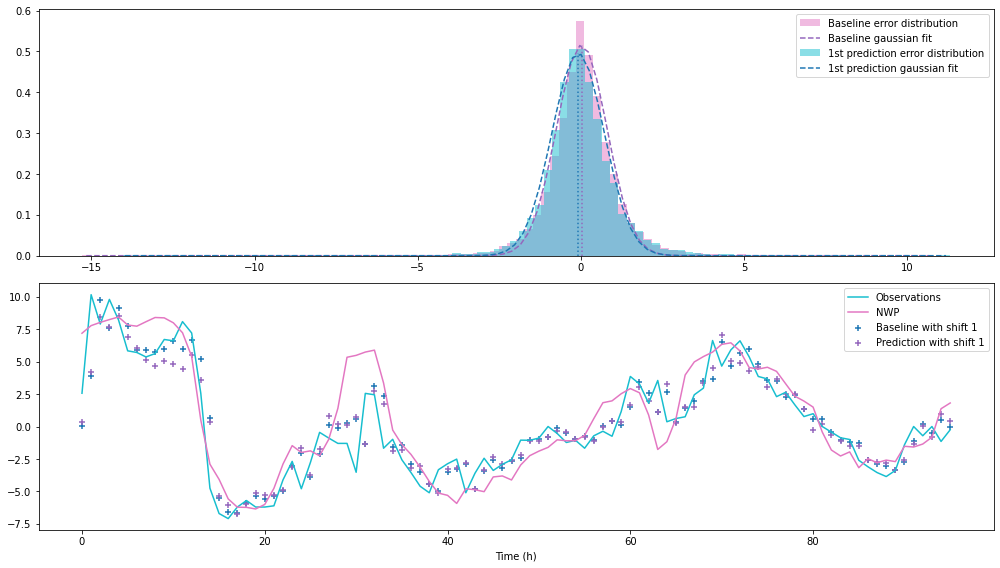

In [16]:
database.plot('wy', y_pred[2], err[2])

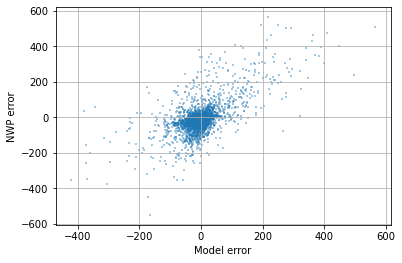

In [17]:
database.error_comparison('ghi', y_pred[0])

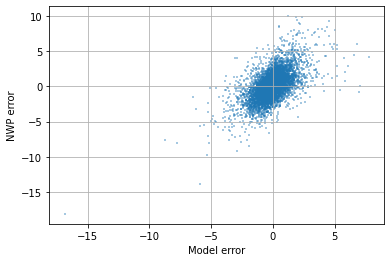

In [18]:
database.error_comparison('wx', y_pred[1])

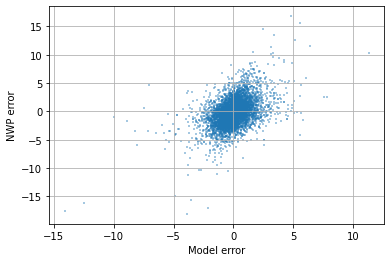

In [19]:
database.error_comparison('wy', y_pred[2])